In [ ]:
from google.colab import drive
drive.mount('/gdrive')
path_to_zip = "/gdrive/My\ Drive/Colab\ Notebooks/IDL_Semester_Task_6/"


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
!pip install -q tf-models-official==2.3.0

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks



In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [ ]:
glue, info = tfds.load('glue/cola', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

In [ ]:
list(glue.keys())

['test', 'train', 'validation']

In [ ]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})

In [ ]:
info.features['label'].names

['unacceptable', 'acceptable']

In [ ]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 1
sentence : b'It is this hat that it is certain that he was wearing.'


In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
tokens = tokenizer.tokenize("Hello, fejriofjerf!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', ',', 'fe', '##j', '##rio', '##f', '##jer', '##f', '!']
[7592, 1010, 10768, 3501, 9488, 2546, 20009, 2546, 999]


In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
glue_train.items()

dict_items([('idx', <tf.Tensor: shape=(8551,), dtype=int32, numpy=array([1680, 1456, 4223, ..., 3624, 8351, 5073], dtype=int32)>), ('label', <tf.Tensor: shape=(8551,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 0, 1])>), ('sentence', <tf.Tensor: shape=(8551,), dtype=string, numpy=
array([b'It is this hat that it is certain that he was wearing.',
       b'Her efficient looking up of the answer pleased the boss.',
       b'Both the workers will wear carnations.', ...,
       b'John looked up the inside of the chimney.',
       b'You said she liked yourself',
       b"What we're using is their teaching material."], dtype=object)>)])

In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train['sentence']])

In [ ]:
print("Sentence1 shape:", sentence1.shape.as_list())

Sentence1 shape: [8551, None]


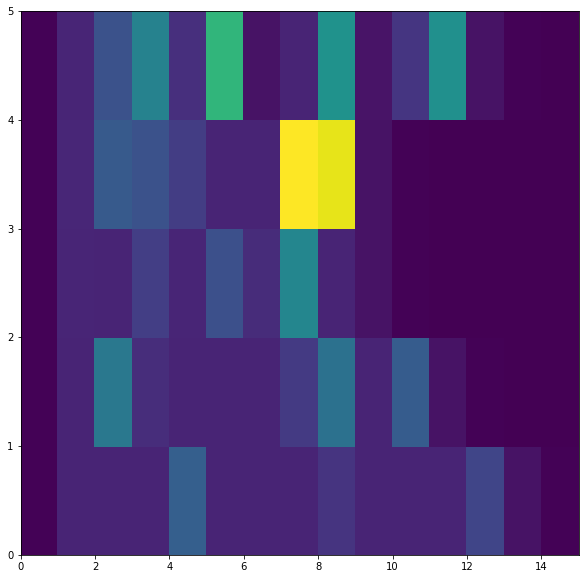

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1], axis=-1)

temp = input_word_ids[:5,:]
fig = plt.figure(figsize=(10,10))
#_ = plt.pcolormesh(input_word_ids.to_tensor())
_ = plt.pcolormesh(temp.to_tensor())

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer) for s in np.array(glue_dict["sentence"])])
#  sentence2 = tf.ragged.constant([
#      encode_sentence(s, tokenizer)
#       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
#  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [ ]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (8551, 47)
input_mask      shape: (8551, 47)
input_type_ids  shape: (8551, 47)
glue_train_labels shape: (8551,)


In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=2)

In [ ]:
transformer_config = config_dict.copy()

# You need to rename a few fields to make this work:
transformer_config['attention_dropout_rate'] = transformer_config.pop('attention_probs_dropout_prob')
transformer_config['activation'] = tf_utils.get_activation(transformer_config.pop('hidden_act'))
transformer_config['dropout_rate'] = transformer_config.pop('hidden_dropout_prob')
transformer_config['initializer'] = tf.keras.initializers.TruncatedNormal(
          stddev=transformer_config.pop('initializer_range'))
transformer_config['max_sequence_length'] = transformer_config.pop('max_position_embeddings')
transformer_config['num_layers'] = transformer_config.pop('num_hidden_layers')

transformer_config

{'activation': <function official.modeling.activations.gelu.gelu>,
 'attention_dropout_rate': 0.1,
 'dropout_rate': 0.1,
 'hidden_size': 768,
 'initializer': <tensorflow.python.keras.initializers.initializers_v2.TruncatedNormal at 0x7fa8c90e6390>,
 'intermediate_size': 3072,
 'max_sequence_length': 512,
 'num_attention_heads': 12,
 'num_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
manual_encoder = nlp.modeling.networks.TransformerEncoder(**transformer_config)

In [ ]:
checkpoint = tf.train.Checkpoint(model=manual_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
my_examples = bert_encode(
    glue_dict = {
        'sentence':['The rain in Spain falls mainly on the plain.',
            'Is it working? This does not match.', 
            'The author of this package has not provided a project description.', 
            'Yoda am I']
    },
    tokenizer=tokenizer)

In [ ]:
result = manual_encoder(my_examples, training=True)

print("Sequence output shape:", result[0].shape)
print("Pooled output shape:", result[1].shape)

Sequence output shape: (4, 14, 768)
Pooled output shape: (4, 768)


In [ ]:
manual_classifier = nlp.modeling.models.BertClassifier(
        manual_encoder,
        num_classes=2,
        dropout_rate=transformer_config['dropout_rate'],
        initializer=tf.keras.initializers.TruncatedNormal(
          stddev=bert_config.initializer_range))

In [ ]:
manual_classifier(my_examples, training=True).numpy()

array([[-3.511565 ,  3.194285 ],
       [-3.7196407,  3.3561697],
       [-3.7100768,  3.3358717]], dtype=float32)

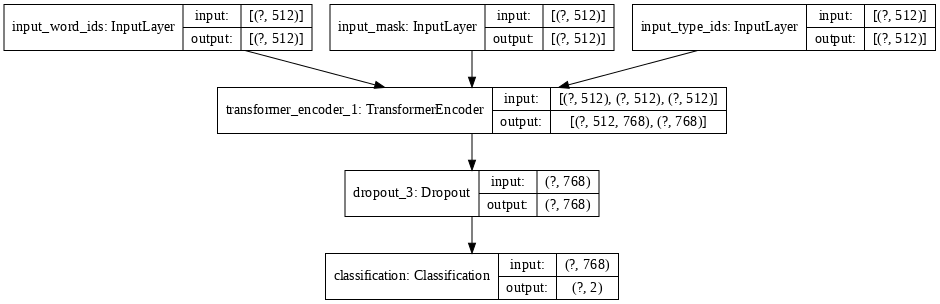

In [ ]:
tf.keras.utils.plot_model(manual_classifier, show_shapes=True, dpi=72)

In [ ]:
glue_train.items()

dict_items([('input_word_ids', <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
array([[ 101, 2009, 2003, ...,    0,    0,    0],
       [ 101, 2014, 8114, ...,    0,    0,    0],
       [ 101, 2119, 1996, ...,    0,    0,    0],
       ...,
       [ 101, 2198, 2246, ...,    0,    0,    0],
       [ 101, 2017, 2056, ...,    0,    0,    0],
       [ 101, 2054, 2057, ...,    0,    0,    0]], dtype=int32)>), ('input_mask', <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>), ('input_type_ids', <tf.Tensor: shape=(8551, 47), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>)])

In [ ]:
glue_batch = {key: val[:600] for key, val in glue_train.items()}

manual_classifier(
    glue_batch, training=True
).numpy()

array([[-0.258938  ,  0.23021258],
       [-0.15101737,  0.09780713],
       [-0.10783275,  0.20325312],
       ...,
       [-0.13750562,  0.18552247],
       [-0.19628634,  0.23876798],
       [-0.277029  ,  0.35035762]], dtype=float32)

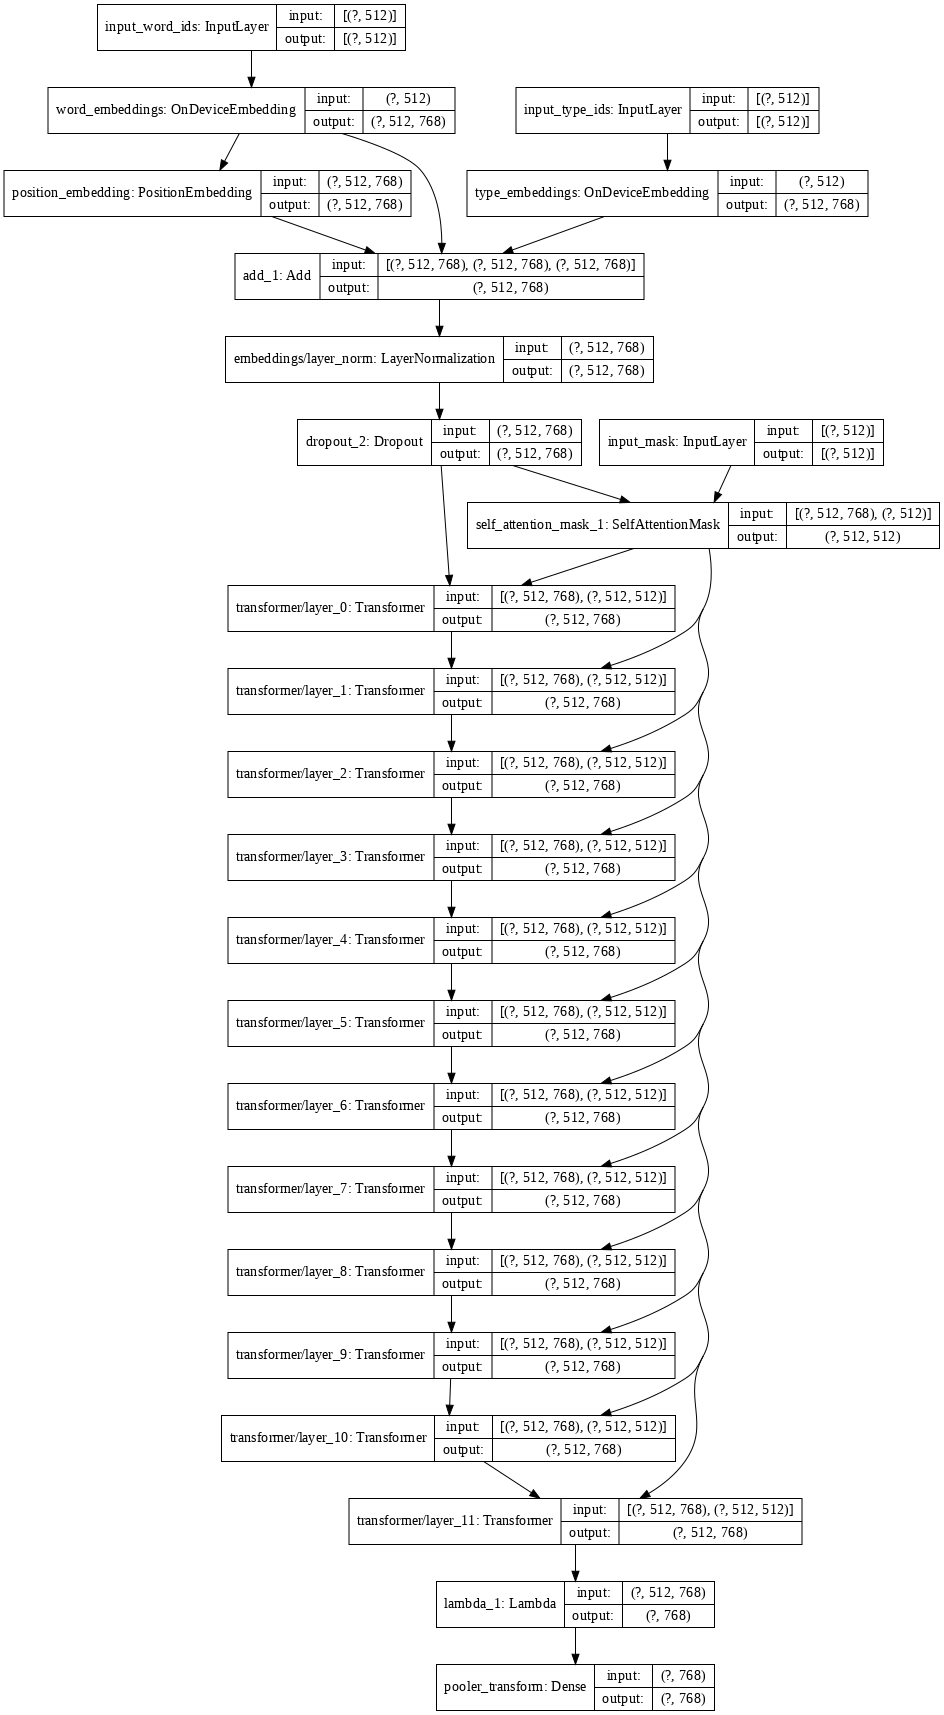

In [ ]:
tf.keras.utils.plot_model(manual_encoder, show_shapes=True, dpi=72)

In [ ]:
# Set up epochs and steps
epochs = 10
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

manual_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

manual_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/10


268/268 [==============================] - ETA: 0s - loss: 0.5367 - accuracy: 0.7406WARNING:tensorflow:Model was constructed with shape (None, 512) for input Tensor("input_word_ids_1:0", shape=(None, 512), dtype=int32), but it was called on an input with incompatible shape (None, 35).


268/268 [==============================] - 160s 597ms/step - loss: 0.5367 - accuracy: 0.7406 - val_loss: 0.4425 - val_accuracy: 0.8044
Epoch 2/10
268/268 [==============================] - 159s 593ms/step - loss: 0.3375 - accuracy: 0.8611 - val_loss: 0.4514 - val_accuracy: 0.8140
Epoch 3/10
268/268 [==============================] - 159s 593ms/step - loss: 0.1897 - accuracy: 0.9317 - val_loss: 0.4783 - val_accuracy: 0.8236
Epoch 4/10
268/268 [==============================] - 159s 592ms/step - loss: 0.1139 - accuracy: 0.9609 - val_loss: 0.6049 - val_accuracy: 0.8255
Epoch 5/10
268/268 [==============================] - 159s 593ms/step - loss: 0.0728 - accuracy: 0.9759 - val_loss: 0.6886 - val_accuracy: 0.8245
Epoch 6/10
268/268 [==============================] - 159s 592ms/step - loss: 0.0443 - accuracy: 0.9856 - val_loss: 0.7213 - val_accuracy: 0.8245
Epoch 7/10
268/268 [==============================] - 159s 592ms/step - loss: 0.0342 - accuracy: 0.9902 - val_loss: 0.8008 - val_accura

In [ ]:
result = manual_classifier(my_examples, training=False)

result = tf.argmax(result, axis=1).numpy()
result

array([1, 1, 1, 0])

In [ ]:
np.array(info.features['label'].names)[result]

array(['acceptable', 'acceptable', 'acceptable', 'unacceptable'],
      dtype='<U12')

### Assignment Questions

- What is the tutorial classifying when using the GLUE MRPC data set?  
Answer: The tutorial uses the GLUE MRPC dataset and classifies the given sentence pairs into equivalent and not-equivalent, on the basis of whether the sentences are semantically correct (i.e. the sentences have the same meaning).
<br>
<br>
- In addition to the input itself, the tutorial feeds two binary tensors for input mask and input type to the model. Is this necessary for the data set single sentence classification?  
Answer: The input data is not of a constant length. The model, therefore, adds padding to make the input data of uniform length. The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding. The "input type" also has the same shape, but inside the non-padded region, contains a 0 or a 1 indicating which sentence the token is a part of. Therefore, even for single sentence classification, the two binary tensors for input mask and input type are required.
<br>
<br>
- How does the tokenization in BERT differ from the one in the previous Task 5?  
Answer: In Task 5, the input was tokenized on the basis of the whitespace character. The input sentence only contained alphabets, digits and the only allowed special characters ".", "?", "!", ",".  
BERT has a fixed, pre-made vocabulary, where each component of the vocabulary is assigned a unique ID. BERT makes use of *WordPiece* algorithm that breaks a word into several subwords, such that commonly seen subwords can be represented by the model.
<pre>
     Hello, fejriofjerf!
</pre>
is tokenized as  
<pre>
     ['hello', ',', 'fe', '##j', '##rio', '##f', '##jer', '##f', '!']  
     [7592, 1010, 10768, 3501, 9488, 2546, 20009, 2546, 999]
</pre>
<br>
<br>
- What is a [CLS] token and what is it used for?  
Answer: For the BERT model, the input is expected to start with a [CLS] "This is a classification problem" token, and each sentence should end with a [SEP] "Separator" token.
<br>
<br>
- Which part of the BERT encoding is used for the classification? Does your answer match the output shape of the encoder?  
Answer: BERT has two outputs, we are taking the second one for classification. Output shape is as expected (batchSize, 768).
<br>
<br>
- Are the BERT encoder weights also fine-tuned to the task?  
Answer: The weights that are updated during fine-tuning belong to the classifier. BERT is only a pre-trained encoder.